In [141]:
import pandas as pd
import numpy  as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [142]:
df= pd.read_table('data/prueba_DS.txt',sep=",")

In [143]:
df.shape
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12559901 entries, 0 to 12559900
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Doc_vtas  int64  
 1   Fecha     object 
 2   Solic     int64  
 3   Material  int64  
 4   Cnt_uni   float64
 5   sect_mat  int64  
 6   Cnt_cart  float64
 7   ValN_Pos  float64
 8   Moneda    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 862.4+ MB


,Doc_vtas,Fecha,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos,Moneda
0,7503277849,2021-11-01,18134244,28424,72.0,42,1.000,347.76,COP
1,7503277849,2021-11-01,18134244,26780,6.0,42,6.000,781.40,COP
2,7503277849,2021-11-01,18134244,28846,72.0,42,1.000,309.05,COP
3,7503277849,2021-11-01,18134244,6572,18.0,42,0.375,124.59,COP
4,7503277849,2021-11-01,18134244,28850,1.0,42,1.000,478.87,COP


Modificando el formato de la fecha

In [144]:
df['Fecha'] = pd.to_datetime(df['Fecha'])
df["Doc_vtas"]=df["Doc_vtas"].apply(str)
df["Solic"]=df["Solic"].apply(str)
df["Material"]=df["Material"].apply(str)
df["sect_mat"]=df["sect_mat"].apply(str)


In [145]:
df.describe()

,Cnt_uni,Cnt_cart,ValN_Pos
count,1.255990e+07,1.255990e+07,1.255990e+07
mean,3.444836e+00,1.092986e+00,8.999391e+01
std,3.343890e+02,3.342218e+02,5.830246e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,5.555600e-02,4.087000e+01
50%,1.000000e+00,8.333300e-02,5.402000e+01
75%,3.000000e+00,1.250000e-01,8.560000e+01
max,2.000000e+05,2.000000e+05,1.242856e+06


Se descartan los registros que tienen valor cero, ya que estos pueden deberse a obsequios o temas de facturacion

In [146]:
df = df[df['ValN_Pos']!=0]

In [147]:
df.shape

(12559132, 9)

In [148]:
print(df['Fecha'].min())
print(df['Fecha'].max())

2021-11-01 00:00:00
2022-07-15 00:00:00


In [149]:
print(df['Doc_vtas'].nunique())
print(df['Solic'].nunique())
print(df['Material'].nunique())
print(df['sect_mat'].nunique())
print(df['Moneda'].nunique())


1660722
80294
899
22
1


<AxesSubplot:ylabel='ValN_Pos'>

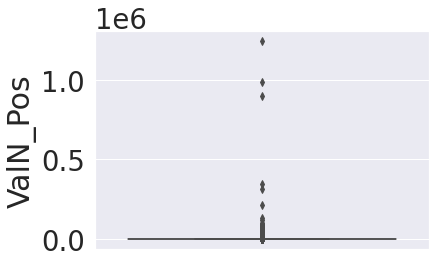

In [150]:
import seaborn as sns
#plt.figure(figsize=(15,10))
sns.boxplot(data=df,y='ValN_Pos')

# Preparacion de los datos para el modelo

Como los clientes tienen varios registros por fecha y material solicitado se debe generar un registro único para cada uno, para poder realizar el modelo predictivo de fuga. Para esto se crean las variables:
* recencia: La cual cuenta los días transcurridos desde la ultima fecha de compra hasta 16 de julio del 2022, esta será la variable de respuesta, si los clientes no han comprado en los ultimos 60 días se clasifica como cliente fugado.
* monto: Es el promedio del valor neto en dinero de cada cliente.
* Frecuencia: cuantas veces ha comprado el cliente por Fecha. (se cuenta en cuantas fechas distintas a comprado cada cliente).
* longitud: fecha max - fecha minima de cada cliente
* periodicidad: Es la desviación estandar de la diferencia de tiempos de compra de cada cliente. Se toma la cantidad de días que han pasado entre cada fecha y a estos se les calcula la desviación estandar. 
* portafolio: Se cuenta la cantidad de productos (Material) que ha comprado cada cliente.


Funciones para la generacion de la nueva base de datos para realizar el modelo

In [151]:
from datetime import datetime

## Funcion para calcular la recencia por cada cliente
def get_recency(x):
        result = pd.Series(datetime.strptime('2022-07-16', '%Y-%m-%d')-x['Fecha'].max()).dt.days
        return np.float64(result)

## Funcion para calcular el monto  por cada cliente
def get_monetary(x):
        return x['ValN_Pos'].mean()

## Funcion para calcular la frecuencia por cada cliente
def get_frequency(x):
        return x['Fecha'].nunique()


## Funcion para calcular la longitud por cada cliente
def get_length(x):
        result = pd.Series(x['Fecha'].max()-x['Fecha'].min()).dt.days
        return np.float64(result)
         
## Funcion para calcular el portafolio por cada cliente
def get_portfolio(x):
        return x['Material'].nunique()


def get_periodicity(x):
        date_uniques = x['Fecha'].unique()
        date_diff = pd.DataFrame({"Fecha":date_uniques})['Fecha'].sort_values().diff()
        sd = pd.Series(date_diff).dt.days.std()
        return sd

# Creacion de la base de datos para realizar el modelo


In [152]:
df_model = df.groupby('Solic').apply(lambda x: pd.Series({
                    "recencia": get_recency(x),
                    "frecuencia":get_frequency(x),
                    "monto": get_monetary(x),
                    "longitud":get_length(x),
                    "portafolio":get_portfolio(x),
                    "periodicidad":get_periodicity(x)
                    })).reset_index().fillna(0)

print(df_model.shape)
df_model.head()

(80294, 7)


,Solic,recencia,frecuencia,monto,longitud,portafolio,periodicidad
0,1000024,5.0,27.0,65.156063,245.0,40.0,5.693316
1,1000026,2.0,42.0,53.422865,255.0,121.0,6.243045
2,1000036,18.0,14.0,40.796234,232.0,28.0,8.896124
3,1000038,5.0,26.0,59.214897,245.0,90.0,6.442049
4,100006,4.0,28.0,48.026402,252.0,62.0,4.411523


Se crea la variable fugado, la cual se basa en la recencia para saber si un cliente es fugado o no.
Si el cliente realizo su ultima compra hace mas de 2 meses (60 dias se considera fugado). Entonces:
fugado = 1; si el cliente lleva mas de 60 dias sin comprar
fugado = 0; en caso contrario

In [153]:
#df_model2 = df_model.copy()
#df_model2.head()

In [154]:
# se crea la variable de respuesta fugados, donde es 1 si los clientes llevan m[as de 60 dias sin comprar
df_model['fugados'] = 0
df_model.loc[df_model['recencia']>=60,'fugados'] = 1

<AxesSubplot:xlabel='fugados', ylabel='monto'>

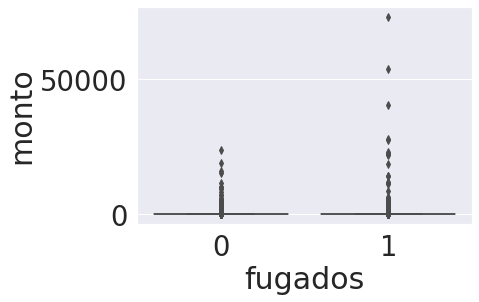

In [155]:
sns.boxplot(data=df_model,x='fugados' , y='monto')

<AxesSubplot:xlabel='fugados', ylabel='frecuencia'>

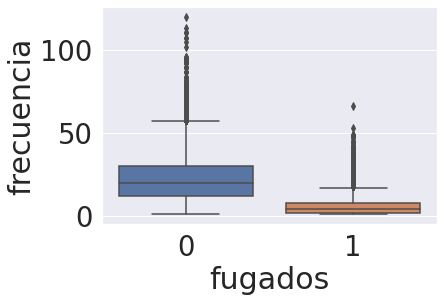

In [156]:
sns.boxplot(data=df_model,x='fugados' , y='frecuencia')

In [157]:
df_model.describe()


,recencia,frecuencia,monto,longitud,portafolio,periodicidad,fugados
count,80294.000000,80294.000000,80294.000000,80294.000000,80294.000000,80294.000000,80294.000000
mean,29.012342,19.811729,94.410206,197.350437,53.399357,8.941806,0.132799
std,50.978171,13.682132,472.252563,75.827921,34.648439,9.770202,0.339360
min,1.000000,1.000000,17.674000,0.000000,1.000000,0.000000,0.000000
25%,4.000000,9.000000,58.283011,175.000000,29.000000,3.950910,0.000000
50%,8.000000,18.000000,68.535351,238.000000,48.000000,6.390097,0.000000
75%,23.000000,28.000000,85.516850,245.000000,71.000000,10.616026,0.000000
max,257.000000,120.000000,73157.360000,256.000000,327.000000,163.341666,1.000000


En este caso la variable de respuesta 'fugados' esta desbalanceada, ya que el 13% de los clientes han dejado de comprar en los últimos dos meses, por tanto es recomendable usar un metodo de desbalanceo previo a la realizacion del modelo. 


En este caso se usara el metodo SMOTE

In [189]:
## Porcentaje de clientes fugados
df_model['fugados'].value_counts()/df_model.shape[0]

0    0.867201
1    0.132799
Name: fugados, dtype: float64

In [159]:
# COlocar en los indices el identificador del clientes
df_model.set_index('Solic', inplace=True)
df_model.index.name = None

In [160]:
df_model.head()

,recencia,frecuencia,monto,longitud,portafolio,periodicidad,fugados
1000024,5.0,27.0,65.156063,245.0,40.0,5.693316,0
1000026,2.0,42.0,53.422865,255.0,121.0,6.243045,0
1000036,18.0,14.0,40.796234,232.0,28.0,8.896124,0
1000038,5.0,26.0,59.214897,245.0,90.0,6.442049,0
100006,4.0,28.0,48.026402,252.0,62.0,4.411523,0


In [161]:
# ELimino recencia, esta no es necesaria, esta relacionada con la variable de respuesta fugados
#
from sklearn.preprocessing import MinMaxScaler

df_model = df_model.drop('recencia', axis=1)

# Se crean X y Y para iniciar el modelo

X= df_model.drop(['fugados'],axis=1)
nombres = X.columns

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

y=df_model['fugados']


In [162]:
df_model.shape

(80294, 6)

Generacion de data test y data train


In [163]:
semilla = 123
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.2,random_state=123 )
#usamos el 20% de los datos para realizar el test 

print("Tamanio del x test:", X_test.shape)
print("Tamanio del y test:", y_test.shape)

print("Tamanio del X train:", X_train.shape)
print("Tamanio del y train:", y_train.shape)


Tamanio del x test: (16059, 5)
Tamanio del y test: (16059,)
Tamanio del X train: (64235, 5)
Tamanio del y train: (64235,)


In [164]:
# Se aplica el metodo de SMOTE
oversample = SMOTE(random_state=semilla)
X_res, y_res = oversample.fit_resample(X_train, y_train)
X_res = pd.DataFrame(X_res, columns= nombres)


print("Tamanio del X train:", X_res.shape)
print("Tamanio del y train:", y_res.shape)

Tamanio del X train: (111310, 5)
Tamanio del y train: (111310,)


In [165]:
y_res.value_counts()#/y_train.shape[0]

0    55655
1    55655
Name: fugados, dtype: int64

In [166]:
X_res.head()


,frecuencia,monto,longitud,portafolio,periodicidad
0,0.243697,0.000580,0.984375,0.312883,0.021897
1,0.201681,0.001094,0.957031,0.273006,0.025273
2,0.268908,0.000364,0.972656,0.180982,0.023825
3,0.226891,0.002440,0.914062,0.144172,0.038831
4,0.033613,0.000596,0.519531,0.079755,0.112707


# Generacion de modelos
Para la generación del modelo predictivo de fuga, se prueban los siguientes métodos:
* Regresión logística 
* Random Forest
* KNN
* Support Vector Machine (SVM)
* Gaussian Naive Bayes (GNB)
* Xgboost

Se elige el modelo que genere las mejores métricas y los menores tiempos de ejecución.

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [168]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    models = [
            ('LogReg', LogisticRegression()), 
            ('RF', RandomForestClassifier()),
           ('KNN', KNeighborsClassifier()),
      #     ('SVM', SVC()), 
            ('GNB', GaussianNB()),
            ('XGB', XGBClassifier(objective= "binary:logistic",eval_metric = "mlogloss",use_label_encoder=False))
            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['No fugado', 'fugado']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names= target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [169]:
df_metodos = run_exps(X_res, y_res.values.ravel(), X_test, y_test.values.ravel())

/home/yarangodev/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


LogReg
              precision    recall  f1-score   support

   No fugado       0.98      0.86      0.92     13976
      fugado       0.49      0.86      0.62      2083

    accuracy                           0.86     16059
   macro avg       0.73      0.86      0.77     16059
weighted avg       0.91      0.86      0.88     16059



/home/yarangodev/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RF
              precision    recall  f1-score   support

   No fugado       0.97      0.90      0.94     13976
      fugado       0.56      0.82      0.67      2083

    accuracy                           0.89     16059
   macro avg       0.77      0.86      0.80     16059
weighted avg       0.92      0.89      0.90     16059



/home/yarangodev/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


KNN
              precision    recall  f1-score   support

   No fugado       0.98      0.88      0.92     13976
      fugado       0.51      0.86      0.64      2083

    accuracy                           0.87     16059
   macro avg       0.74      0.87      0.78     16059
weighted avg       0.92      0.87      0.89     16059



/home/yarangodev/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


GNB
              precision    recall  f1-score   support

   No fugado       0.97      0.88      0.92     13976
      fugado       0.49      0.79      0.61      2083

    accuracy                           0.87     16059
   macro avg       0.73      0.83      0.76     16059
weighted avg       0.90      0.87      0.88     16059

XGB
              precision    recall  f1-score   support

   No fugado       0.97      0.91      0.94     13976
      fugado       0.57      0.84      0.68      2083

    accuracy                           0.90     16059
   macro avg       0.77      0.87      0.81     16059
weighted avg       0.92      0.90      0.91     16059



In [170]:
df_metodos

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.221451,0.024065,0.869104,0.869124,0.869104,0.869104,0.931524,LogReg
1,0.125982,0.017111,0.870272,0.870274,0.870272,0.870272,0.933840,LogReg
2,0.131655,0.017962,0.857964,0.857980,0.857964,0.857968,0.926522,LogReg
3,0.135363,0.018161,0.865151,0.865198,0.865151,0.865143,0.928673,LogReg
4,0.130172,0.017642,0.862816,0.862814,0.862816,0.862813,0.930009,LogReg
5,0.149565,0.017838,0.865241,0.865244,0.865241,0.865242,0.929832,LogReg
6,0.129434,0.017429,0.864433,0.864436,0.864433,0.864432,0.932147,LogReg
7,0.155930,0.017939,0.868565,0.868582,0.868565,0.868567,0.931703,LogReg
8,0.099857,0.017073,0.864972,0.864997,0.864972,0.864974,0.929169,LogReg
9,0.132921,0.016890,0.867308,0.867320,0.867308,0.867310,0.931441,LogReg


In [171]:
bootstraps = []

for model in list(set(df_metodos.model.values)):
    model_df = df_metodos.loc[df_metodos.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)

In [172]:
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics

In [173]:
## Metricas
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # obtener el dataframe sin los fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

In [174]:
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # data frame con los fit data
results_long_fit = results_long_fit.sort_values(by='values')
results_long_fit

,model,metrics,values
210,GNB,score_time,0.011952
215,GNB,score_time,0.011952
216,GNB,score_time,0.011952
221,GNB,score_time,0.012073
214,GNB,score_time,0.012073
...,...,...,...
131,RF,fit_time,9.721517
141,RF,fit_time,9.721517
149,RF,fit_time,9.721517
134,RF,fit_time,9.726634


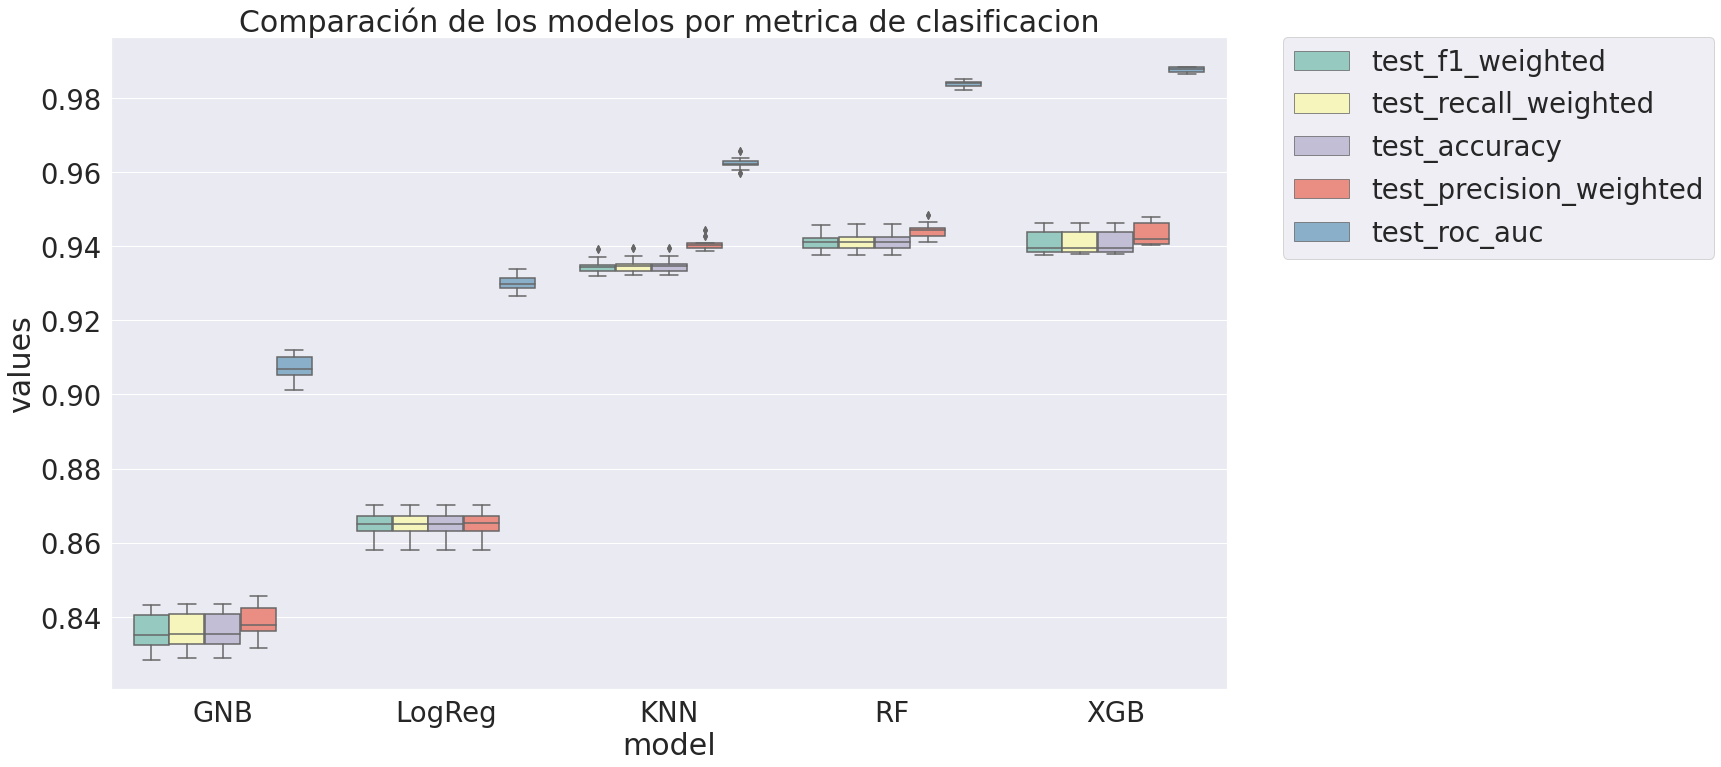

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparación de los modelos por metrica de clasificacion')
plt.savefig('./img/boxplot_metricas_clasificacion.png',dpi=300)

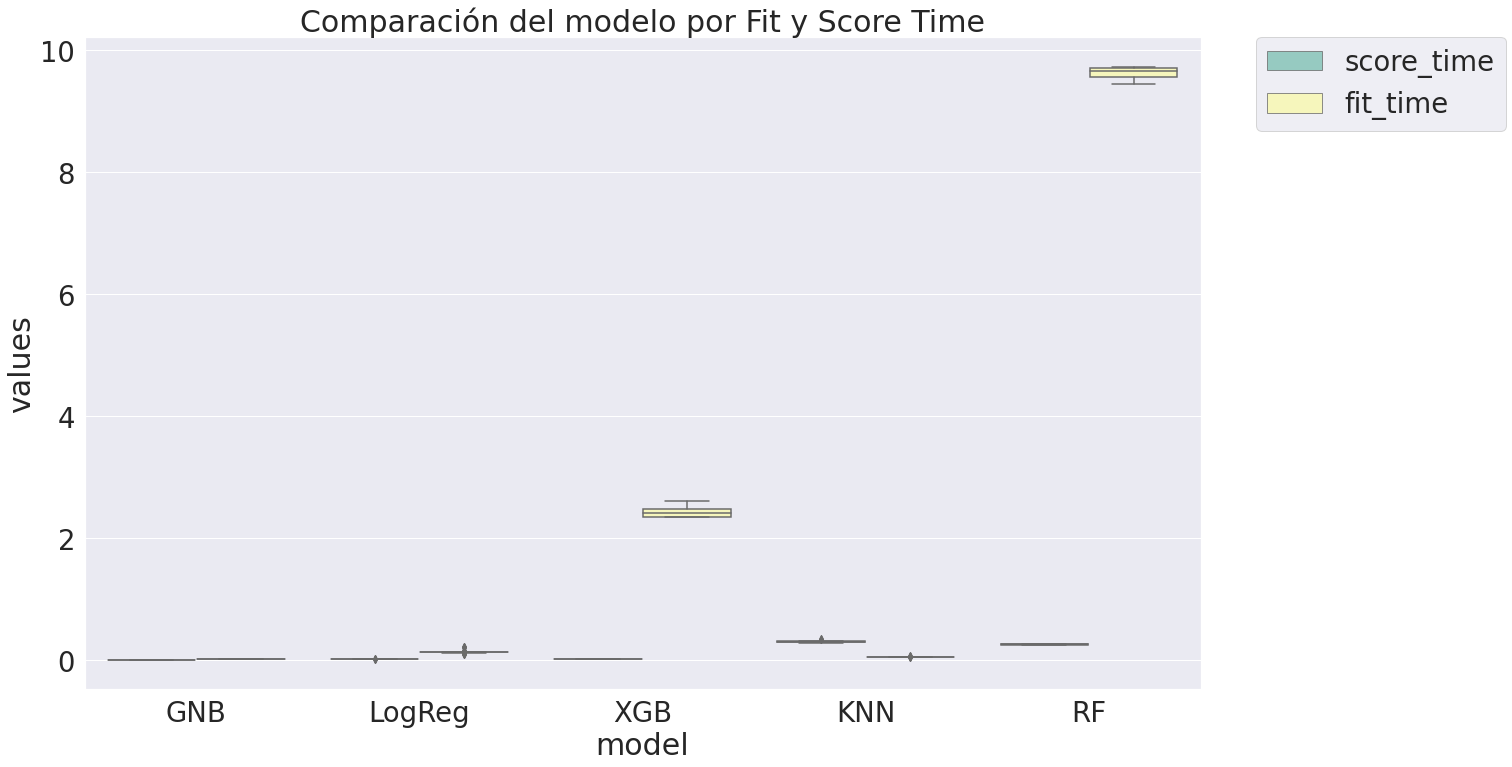

In [191]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparación del modelo por Fit y Score Time')
plt.savefig('./img/boxplot_tiempos_modelos.png',dpi=300)

In [177]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_f1_weighted           test_roc_auc           test_recall_weighted  \
                    std      mean          std      mean                  std   
model                                                                           
GNB            0.004651  0.835743     0.002841  0.907632             0.004596   
KNN            0.001787  0.934470     0.001413  0.962503             0.001780   
LogReg         0.004158  0.864481     0.002385  0.929816             0.004159   
RF             0.002157  0.941036     0.000861  0.983897             0.002149   
XGB            0.002988  0.940771     0.000591  0.987692             0.002992   

                 test_precision_weighted           test_accuracy            
            mean                     std      mean           std      mean  
model                                                                       
GNB     0.836043                0.004235  0.838672      0.004596  0.836043  
KNN     0.934690                0.001491  0.940434      0.001780  0.934690  
LogReg  0.864481                0.004159  0.864497      0.004159  0.864481  
RF      0.941134                0.001867  0.944095      0.002149  0.941134  
XGB     0.940838                0.002867  0.943047      0.002992  0.940838

In [178]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])


score_time            fit_time          
              std      mean       std      mean
model                                          
GNB      0.000125  0.012190  0.000772  0.015938
KNN      0.013012  0.305644  0.000666  0.061987
LogReg   0.002007  0.018276  0.030490  0.139795
RF       0.001986  0.260882  0.091370  9.629598
XGB      0.005078  0.020998  0.093704  2.440721

# Modelo elegido

El metodo Xgboost, es el que logra clasificar el modelo de mejor manera, ya que tanto el recall y la precision son altos, ademas viendo las grafica de las metricas de clasificacion son mejores comparados con los demas modelos. En el tiempo de ajuste del estimador si es un poco demorado con respecto a los demas modelos, sin embargo la diferencia no es tan grande.

In [179]:
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=90210)


In [180]:
modelo =  XGBClassifier(objective= "binary:logistic",eval_metric = "mlogloss",use_label_encoder=False)

In [181]:
modelo.fit(X_res,y_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [182]:
## predicciones
y_pred_proba = modelo.predict_proba(X_test)[:,1]
y_train_pred = modelo.predict(X_res)
y_test_pred=modelo.predict(X_test)

print('matríz de confusion en entrenamiento')
cf_matrix = confusion_matrix(y_res, y_train_pred)
print(cf_matrix)

print('matríz de confusion en test')
cf_matrix = confusion_matrix(y_test, y_test_pred)
print(cf_matrix)

print('métricas en entrenamiento')
print(classification_report(y_res,y_train_pred))

print('métricas en test')
print(classification_report(y_test,y_test_pred))

matríz de confusion en entrenamiento
[[51433  4222]
 [  844 54811]]
matríz de confusion en test
[[12677  1299]
 [  339  1744]]
métricas en entrenamiento
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     55655
           1       0.93      0.98      0.96     55655

    accuracy                           0.95    111310
   macro avg       0.96      0.95      0.95    111310
weighted avg       0.96      0.95      0.95    111310

métricas en test
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     13976
           1       0.57      0.84      0.68      2083

    accuracy                           0.90     16059
   macro avg       0.77      0.87      0.81     16059
weighted avg       0.92      0.90      0.91     16059



importancia de variables


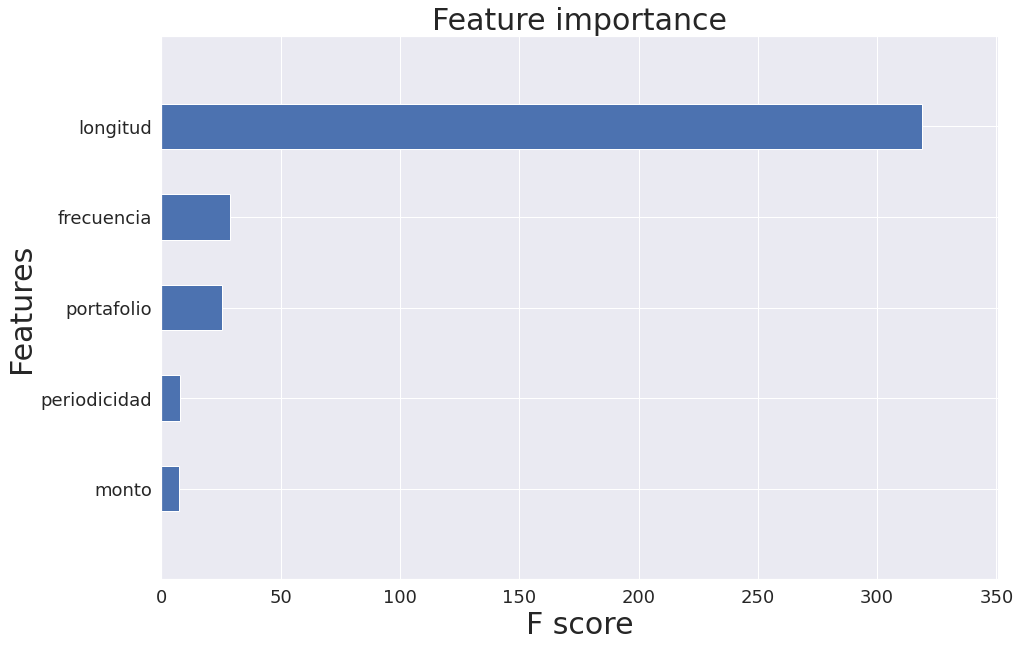

In [192]:
#Importancia de las variables
print('importancia de variables')
ax = xgb.plot_importance(modelo, max_num_features =10, importance_type='gain',height=0.5,show_values=False)
fig = ax.figure
fig.set_size_inches(15, 10)
plt.tick_params(labelsize = 18)
plt.savefig('./img/importancia_variables.png',dpi=300)

In [184]:
 predicciones = modelo.predict(X)

df_model.index

Index(['1000024', '1000026', '1000036', '1000038', '100006', '1000074',
       '1000092', '1000116', '1000122', '1000126',
       ...
       '99874', '99884', '99886', '99910', '99926', '99930', '99948', '99954',
       '99968', '99992'],
      dtype='object', length=80294)

In [185]:
df_salida = pd.DataFrame({
  'clientes':df_model.index,
  'real':df_model['fugados'],
  'prediccion':predicciones
})


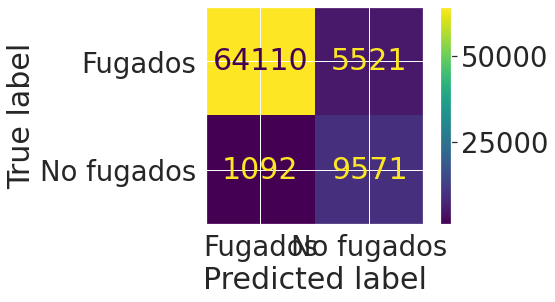

In [186]:
from sklearn import metrics

matrix_confusion = confusion_matrix(df_salida['real'], df_salida['prediccion'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix_confusion, display_labels = ['Fugados', 'No fugados'])

cm_display.plot()
plt.show()

In [187]:
#np.savetxt('./data/predicciones_modelo.txt',df_salida[['clientes','prediccion']], delimiter=';',fmt='%d')

df_salida[['clientes','prediccion']].to_csv(r'./data/predicciones_modelo.txt', index=None, sep=';', mode='a')